# Analysis robustness of PLIER models based on GTEx

Compare the various parameters of PLIER GTEx models across different computations to evaluate PLIER's robustness, utilizing identical parameters for assessment.

In [1]:
INPUT_PLIER_ROB_DIR=NULL

In [2]:
# Parameters
INPUT_PLIER_ROB_DIR = "output/gtex/robustness"


## Load libraries and data

In [3]:
suppressPackageStartupMessages({
    
    library(dplyr)
    library(tidyr)
    library(UpSetR)
    library(ggplot2)
    library(ComplexHeatmap)
    library(reshape2)
    library(corrr)
    
})

#load functions
source(here::here('scripts/plier_util.R'))

# move functions to a Rscript?
check_all_equal_in_list <- function(lst) {
  # Check if all values in the list are equal
  all_equal <- all(sapply(lst, function(x) identical(x, lst[[1]])))
  
  # Print message based on the result
  if (all_equal) {
    print("All values in the list are equal.")
  } else {
    print("Values in the list are not all equal.")
  }
  
}

jaccard_index <- function(a, b) {
    intersection = length(intersect(a, b))
    union = length(a) + length(b) - intersection
    return (intersection/union)
}

return_dim_check=function(matrix_M_list){

    dimensions_list <- lapply(matrix_M_list, function(df) {
      return(dim(df))
    })
    
    # Check if all data frames have the same number of rows and columns
    all_same_dimensions <- all(sapply(dimensions_list, function(x) all(x == dimensions_list[[1]])))
    
    # Print the result
    if (all_same_dimensions) {
      print("All data frames have the same number of rows and columns.")
    } else {
      print("Not all data frames have the same number of rows and columns.")
    }
                                  
}

calculate_pearson_matrices=function(matrix_M_list){

    # Calculate Pearson correlations for each pair of matrices
    correlation_results <- list()
    
    # Iterate over all unique pairs of matrices
    for (i in 1:(length(matrix_M_list) - 1)) {
      for (j in (i + 1):length(matrix_M_list)) {
        # Initialize a vector to store correlations for this pair
        correlations <- c()
        
        # Ensure both matrices have the same columns
        common_c <- intersect(names(matrix_M_list[[i]]), names(matrix_M_list[[j]]))
        
        # Calculate correlations for each common colums
        for (c in common_c) {
          correlations[c] <- cor(matrix_M_list[[i]][[c]], matrix_M_list[[j]][[c]], method = "pearson")
        }
        
        # Store the correlations with a named key indicating the pair
        comparison_name <- paste(names(matrix_M_list)[i], "vs", names(matrix_M_list)[j])
        correlation_results[[comparison_name]] <- correlations
      }
    }
    
    # Initialize an empty dataframe for heatmap data
    heatmap_data <- data.frame()
    
    # Loop through each comparison result to build the dataframe
    for (comparison_name in names(correlation_results)) {
      temp_df <- data.frame(t(correlation_results[[comparison_name]]))
      colnames(temp_df) <- names(correlation_results[[comparison_name]])
      temp_df$Comparison <- comparison_name
      
      # Bind this comparison's results to the heatmap data
      heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # Reorder dataframe to have Comparison as the first column
    heatmap_data <- heatmap_data[, c(ncol(heatmap_data), 1:(ncol(heatmap_data)-1))]
    
}

## Robustness analysis

Extract all the parameters in the PLIER module for each GTEx module and create a list for each parameter and load models into a list object. 

In [4]:
gtex_rob_model_paths=list.files(INPUT_PLIER_ROB_DIR,
                                pattern="\\.rds",
                                full.names=TRUE)

gtex_rob_model_paths=gtex_rob_model_paths[1:3]

parameters_to_keep <- c("L1", "L2", "L3", "B", "C", "heldOutGen", "residual", "summary", "U", "Uauc", "Z", "Up", "withPrior")

# Initialize a list to store the extracted values for each parameter, considering their data types
extracted_values <- setNames(lapply(parameters_to_keep, function(x) list()), parameters_to_keep)

# Function to handle different types of data structures
handle_data_type <- function(data, param) {
  # Depending on the specific requirements or handling you need for each type, adjust here
  return(data[[param]])
}

# Read each file once and extract all specified parameters, handling them based on their type
all_models_data <- lapply(gtex_rob_model_paths, function(file_path) {
  plier_model <- readRDS(file_path)
  # Extract and handle each needed parameter for this model
  needed_params <- sapply(parameters_to_keep, function(param) handle_data_type(plier_model, param), simplify = FALSE)
  names(needed_params) <- parameters_to_keep
  return(needed_params)
})

# Organize the extracted data by parameter
for(param in parameters_to_keep) {
  extracted_values[[param]] <- lapply(all_models_data, function(model_data) model_data[[param]])
}

                                      
gtex_rob_model_paths=list.files(INPUT_PLIER_ROB_DIR,
    pattern="\\.rds",
    full.names=TRUE)
                                    
# All models into a list
gtex_rob_models=lapply(gtex_rob_model_paths, readRDS)

**Are the L1, L2 and L3 parameters identical along the different GTEx models run?**

**L1**

In [5]:
extracted_values$L1
check_all_equal_in_list(extracted_values$L1)                          

[[1]]
[1] 27.76998

[[2]]
[1] 27.76998

[[3]]
[1] 27.76998

[1] "All values in the list are equal."


**L2**

In [6]:
extracted_values$L2
check_all_equal_in_list(extracted_values$L2)                          

[[1]]
[1] 55.53997

[[2]]
[1] 55.53997

[[3]]
[1] 55.53997

[1] "All values in the list are equal."


**L3**

In [7]:
extracted_values$L3
check_all_equal_in_list(extracted_values$L3)                          

[[1]]
[1] 0.001033298

[[2]]
[1] 0.001033298

[[3]]
[1] 0.001033298

[1] "All values in the list are equal."


**Are the top pathways (FDR < 0.01, AUC > 0.95) present in all the models?**

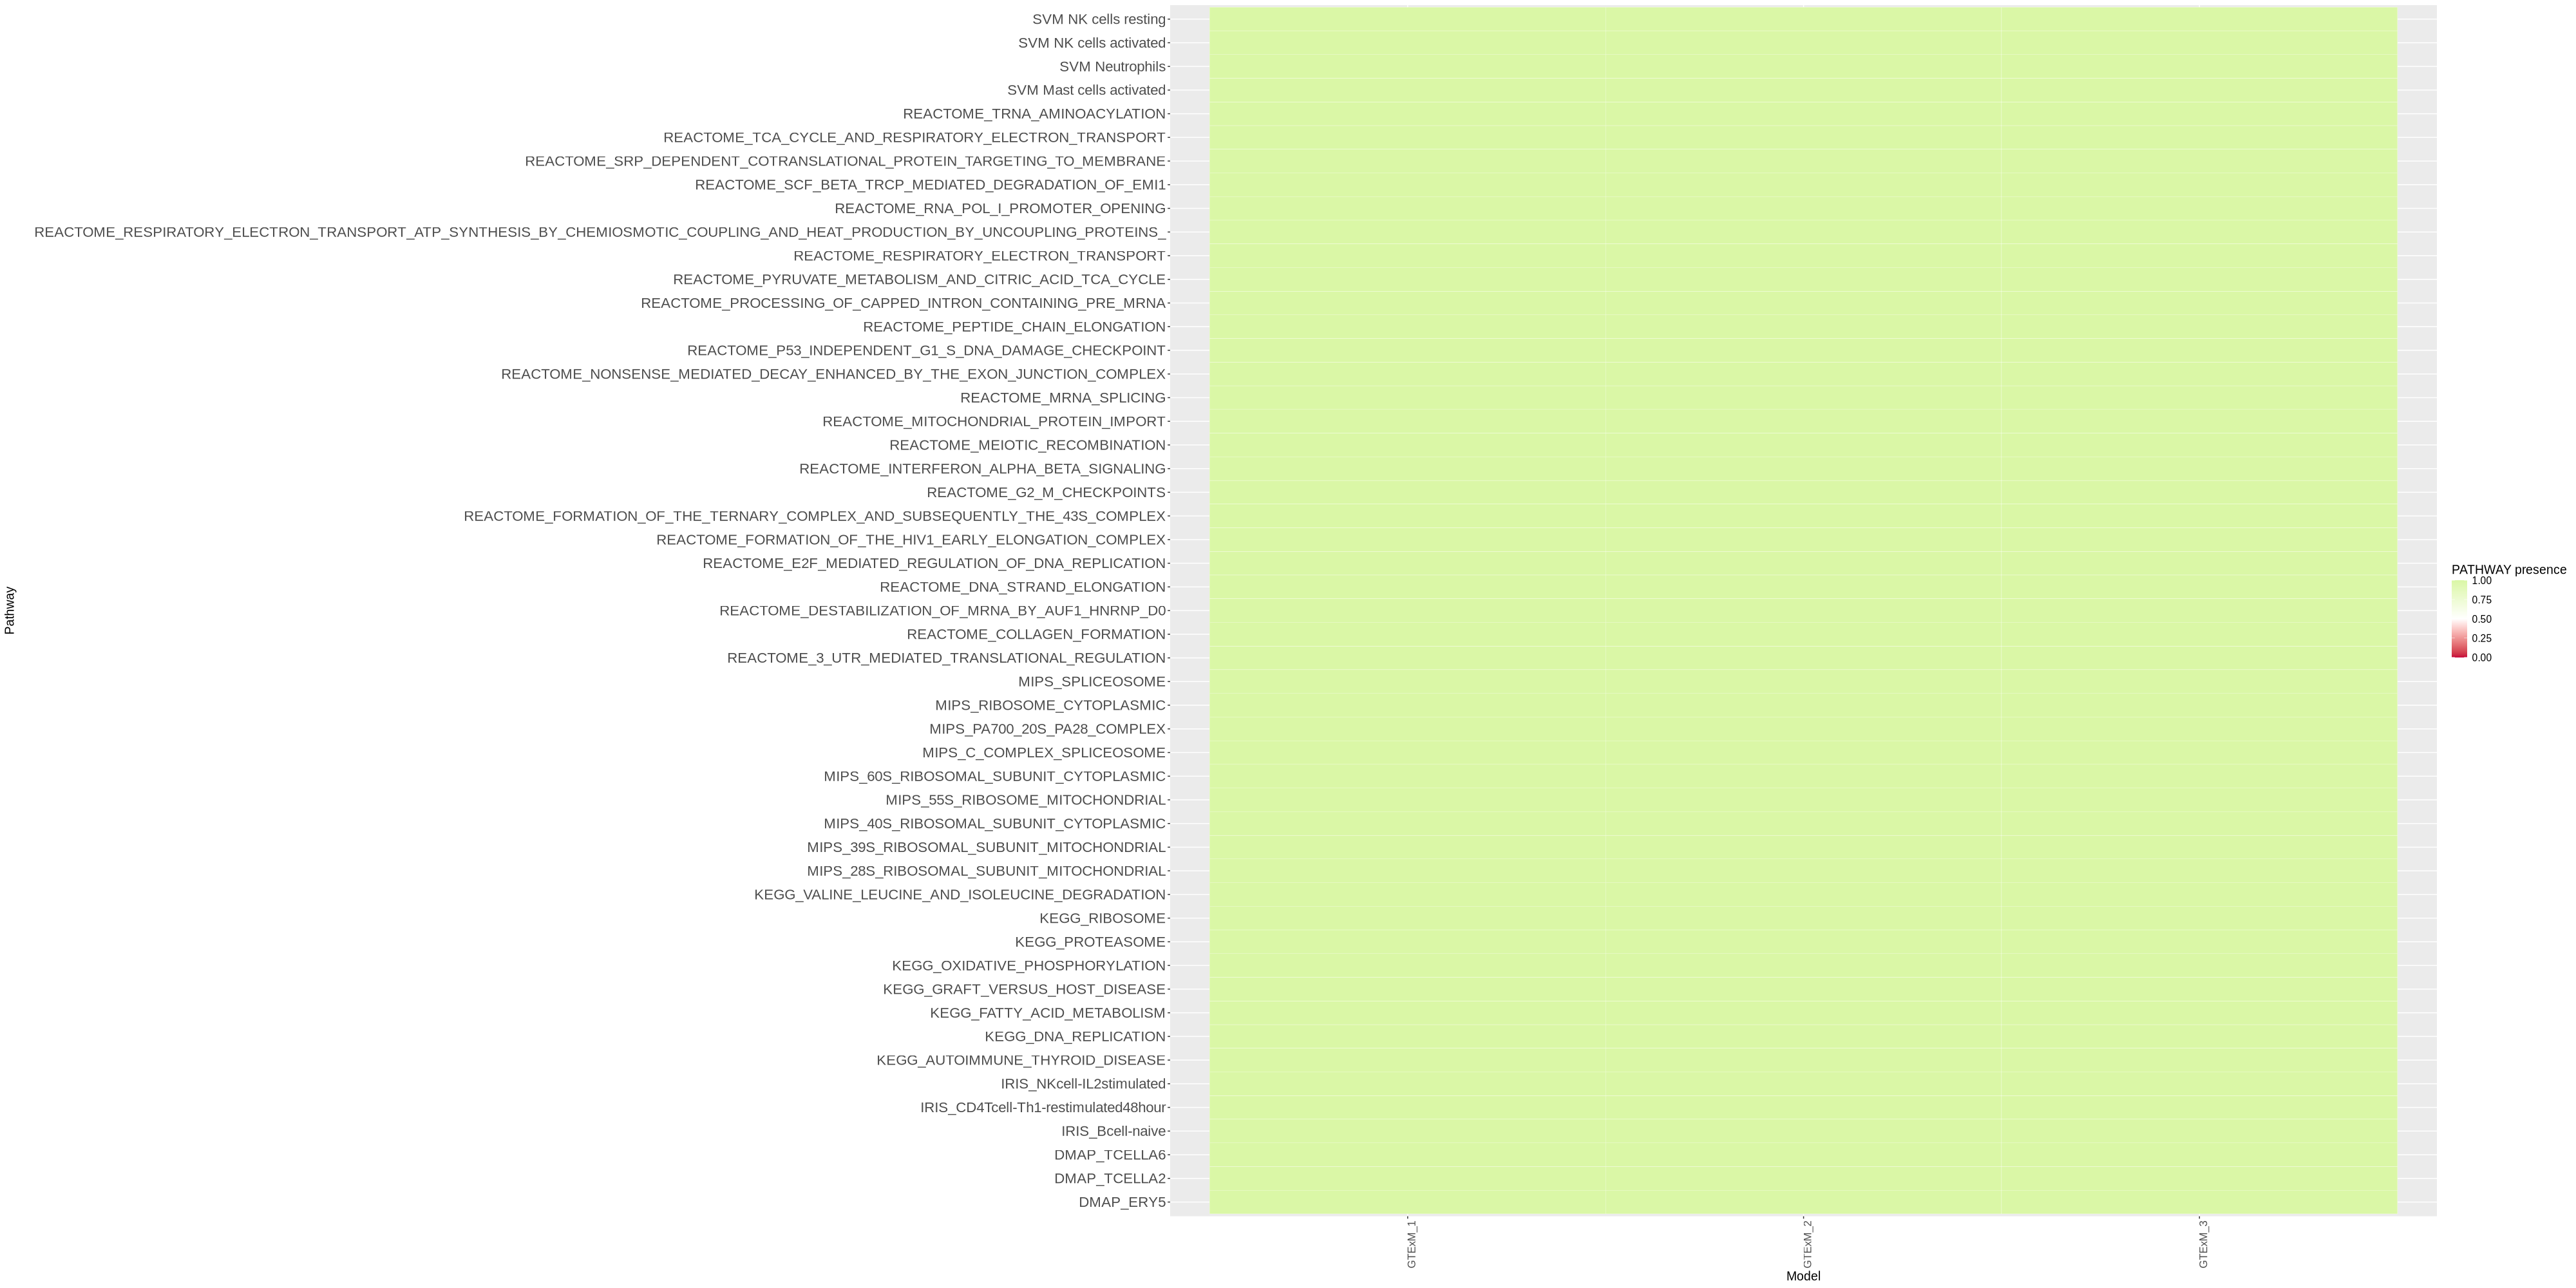

In [8]:
options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)

filtered_summaries <- lapply(extracted_values$summary, function(df) {
  df %>%
    filter(FDR < 0.01, AUC > 0.95)
})

combined <- bind_rows(filtered_summaries, .id = "model") %>%
  select(model, pathway) %>%
  distinct() %>%
  mutate(presence = 1) %>%
  pivot_wider(names_from = model, values_from = presence, values_fill = list(presence = 0))

mat_combined=combined
mat_combined$pathway=NULL
colnames(mat_combined)=paste0('GTExM_', 1:ncol(mat_combined))
mat_combined=as.matrix(mat_combined)
rownames(mat_combined)=combined$pathway

# Convert matrix to dataframe
mat_df <- as.data.frame(mat_combined)
mat_df$pathway <- rownames(mat_df)

# Melt the data for ggplot2
melted_mat <- melt(mat_df, id.vars = "pathway")

# Plot heatmap using ggplot2
ggplot(melted_mat, aes(x = variable, y = pathway, fill = value)) +
    geom_tile(color = "white") +
    scale_fill_gradient2(low = "#C70039", high = "#DAF7A6", mid = "white", midpoint = 0.5, limit = c(0, 1), space = "Lab", name = "PATHWAY presence") +
    labs(x = "Model", y = "Pathway", fill = "PATHWAY presence") +
    theme(
    axis.text.x = element_text(size = 12, angle = 90, hjust = 1),  
    axis.text.y = element_text(size = 16),  
    text = element_text(size = 14)  
  )

**How are the correlations of Z matrix along the different models?**

In [9]:
# Load all the RDS files, extract the head of the Z element, and save into a named list
matrixZ_M_list <- lapply(seq_along(gtex_rob_model_paths), function(i) {
  # Load the RDS file
  tmp_gtex <- readRDS(gtex_rob_model_paths[i])
  
  # Extract the first few elements of the Z column
  head_Z <- head(tmp_gtex$Z, 100)
  
  # Return as a data frame
  return(data.frame(head_Z))
})

# Naming the list elements according to the filenames in gtex_rob_model_paths
names(matrixZ_M_list) <- paste0("matrixZ_M", seq_along(gtex_rob_model_paths))

# If you need the names to reflect the original filenames more closely, you could do:
names(matrixZ_M_list) <- sapply(strsplit(basename(gtex_rob_model_paths), "\\."), `[`, 1)

matrixZ_M_list <- lapply(matrixZ_M_list, function(df) {
  # Generate new column names based on the number of columns
  new_col_names <- paste0('LV_', 1:ncol(df))
  
  # Assign the new names to the columns of the data frame
  colnames(df) <- new_col_names
  
  # Return the modified data frame
  return(df)
})

Do the present the same number of LVs and genes?

In [10]:
return_dim_check(matrixZ_M_list)

[1] "All data frames have the same number of rows and columns."


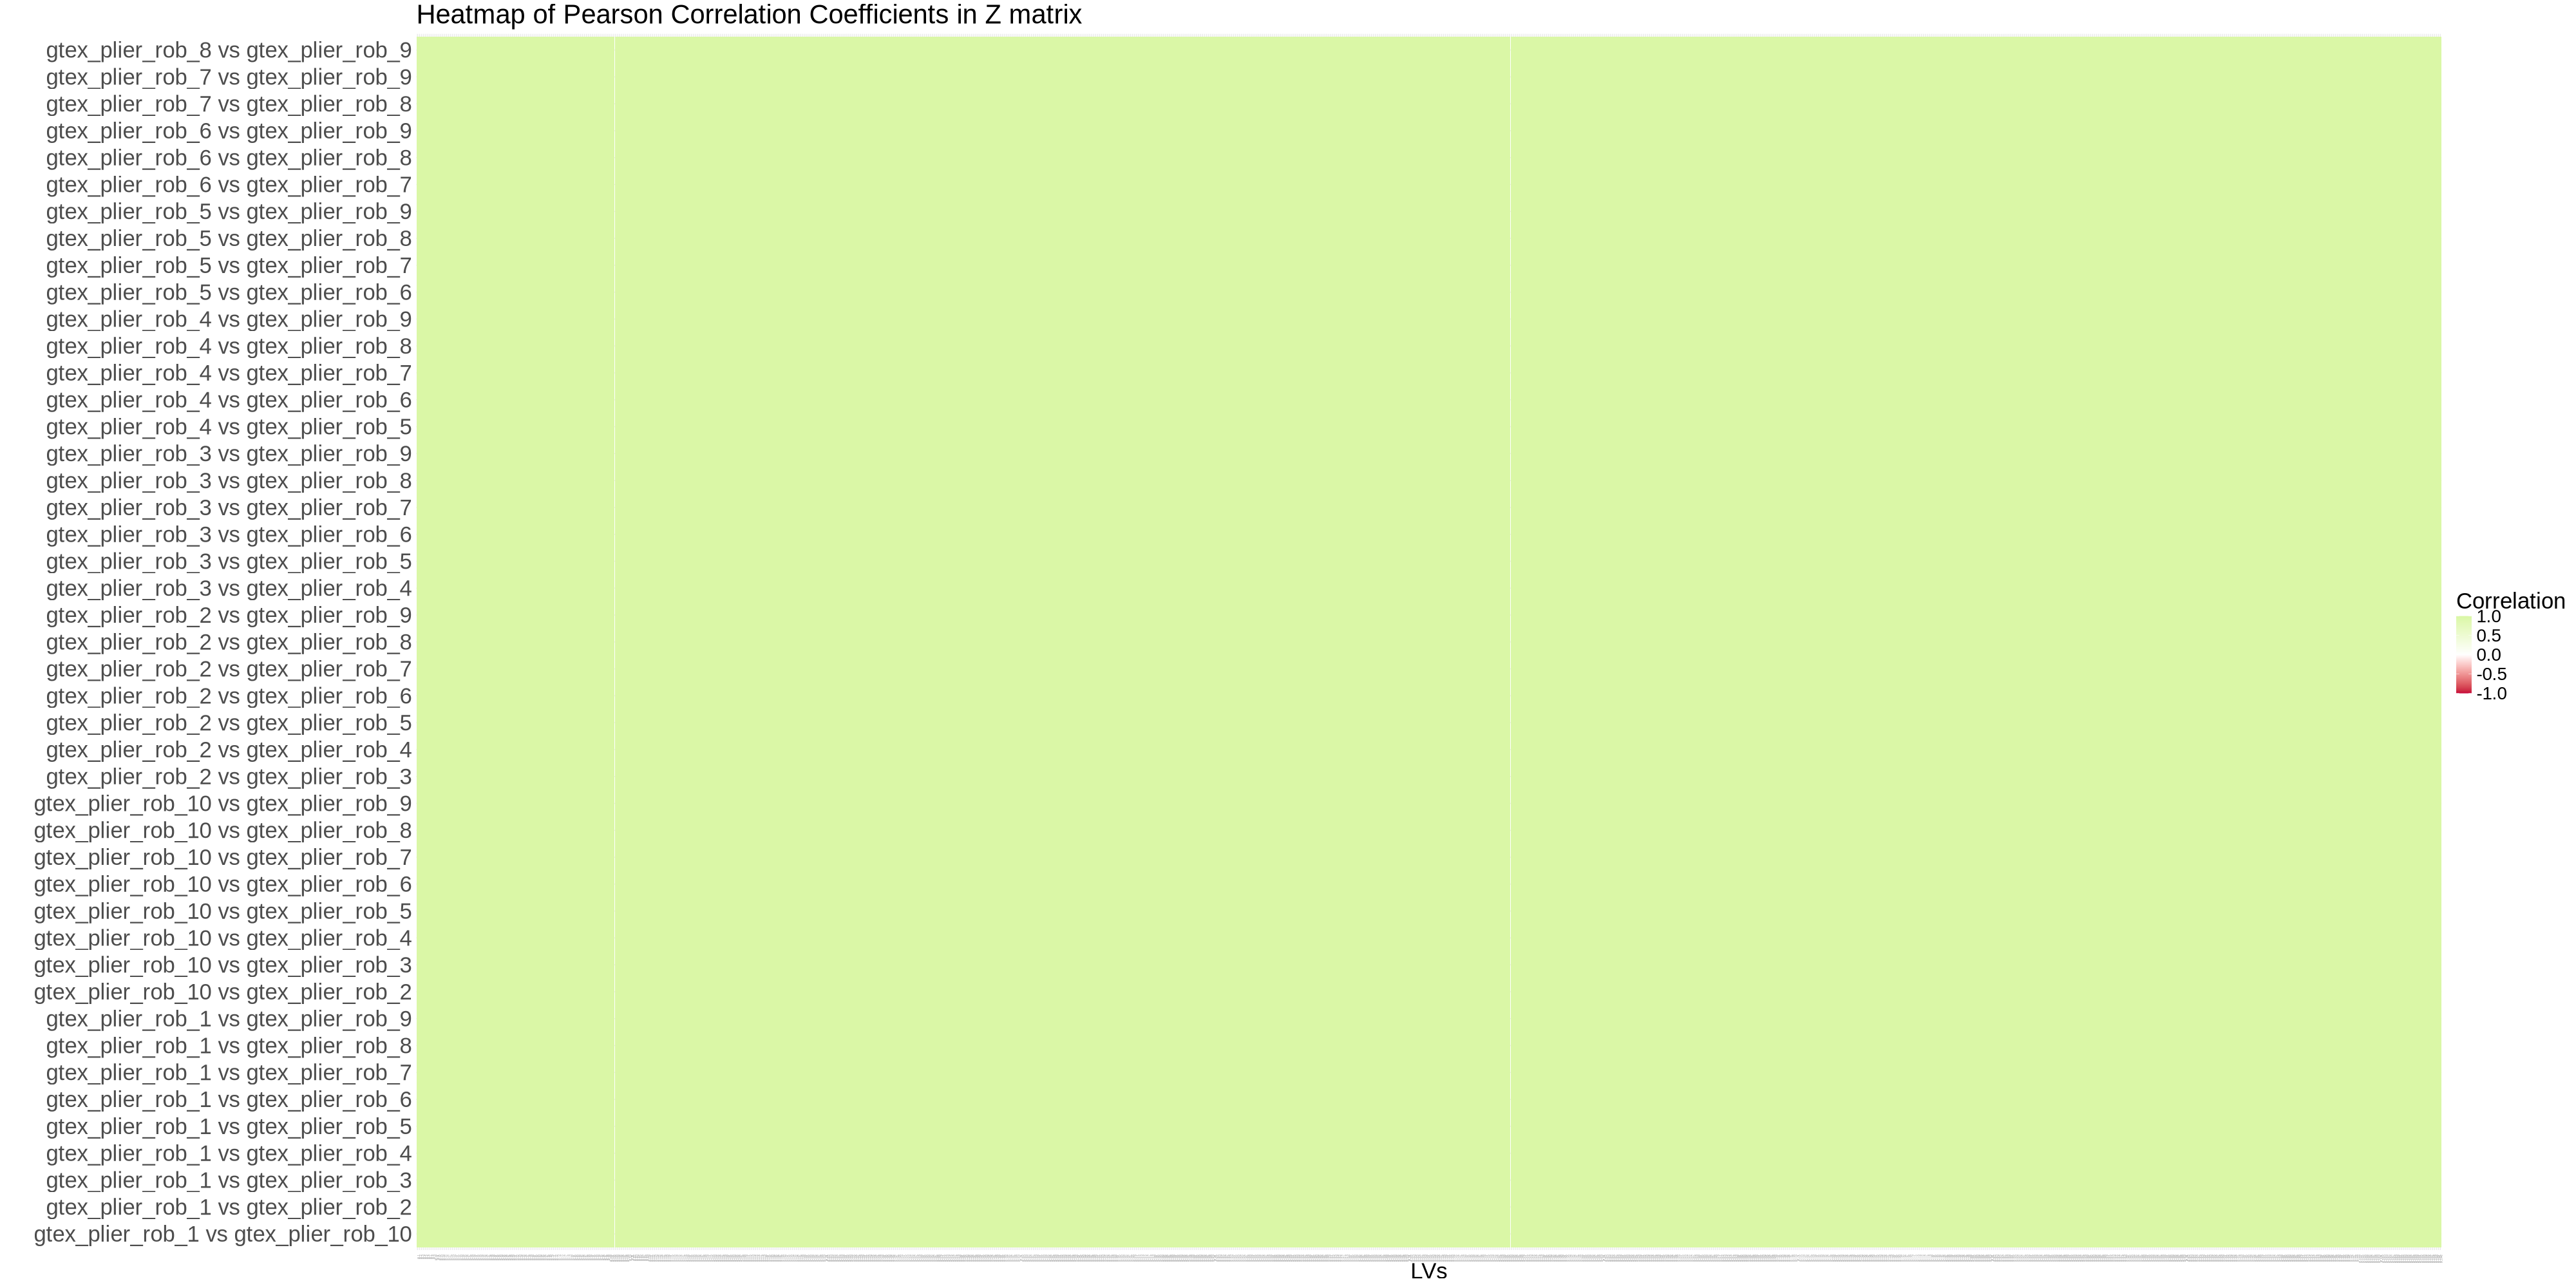

In [11]:
options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)

heatmap_data_lv=calculate_pearson_matrices(matrixZ_M_list)

ggplot(melt(heatmap_data_lv, id.vars = "Comparison"), aes(x = variable, y = Comparison, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "#C70039", high = "#DAF7A6", mid = "white", midpoint = 0, limit = c(-1, 1), space = "Lab", name = "Correlation") +
  labs(title = "Heatmap of Pearson Correlation Coefficients in Z matrix", x = "LVs", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 2, angle = 90, hjust = 1),  # Rotate x-axis labels by 90 degrees
    axis.text.y = element_text(size = 25),  # Adjust y-axis text size
    text = element_text(size = 25)  # Adjust other text sizes (plot title, axis labels, etc.)
  )

**How are the correlations of B matrix along the different models?**

In [12]:
# Load all the RDS files, extract the head of the Z element, and save into a named list
matrixB_M_list <- lapply(seq_along(gtex_rob_model_paths), function(i) {
  # Load the RDS file
  tmp_gtex <- readRDS(gtex_rob_model_paths[i])
  
  # Extract the first few elements of the Z column
  head_B <- head(tmp_gtex$B, 100)
  
  # Return as a data frame
  return(data.frame(head_B))
})

# Naming the list elements according to the filenames in gtex_rob_model_paths
names(matrixB_M_list) <- paste0("matrixB_M", seq_along(gtex_rob_model_paths))

# If you need the names to reflect the original filenames more closely, you could do:
names(matrixB_M_list) <- sapply(strsplit(basename(gtex_rob_model_paths), "\\."), `[`, 1)

matrixB_M_list <- lapply(matrixB_M_list, function(df) {

    df=data.frame(t(df), check.names = FALSE)
  
    # Return the modified data frame
    return(df)
    
})

Do the present the same number of PATHWAYS and samples?

In [13]:
return_dim_check(matrixB_M_list)

[1] "All data frames have the same number of rows and columns."


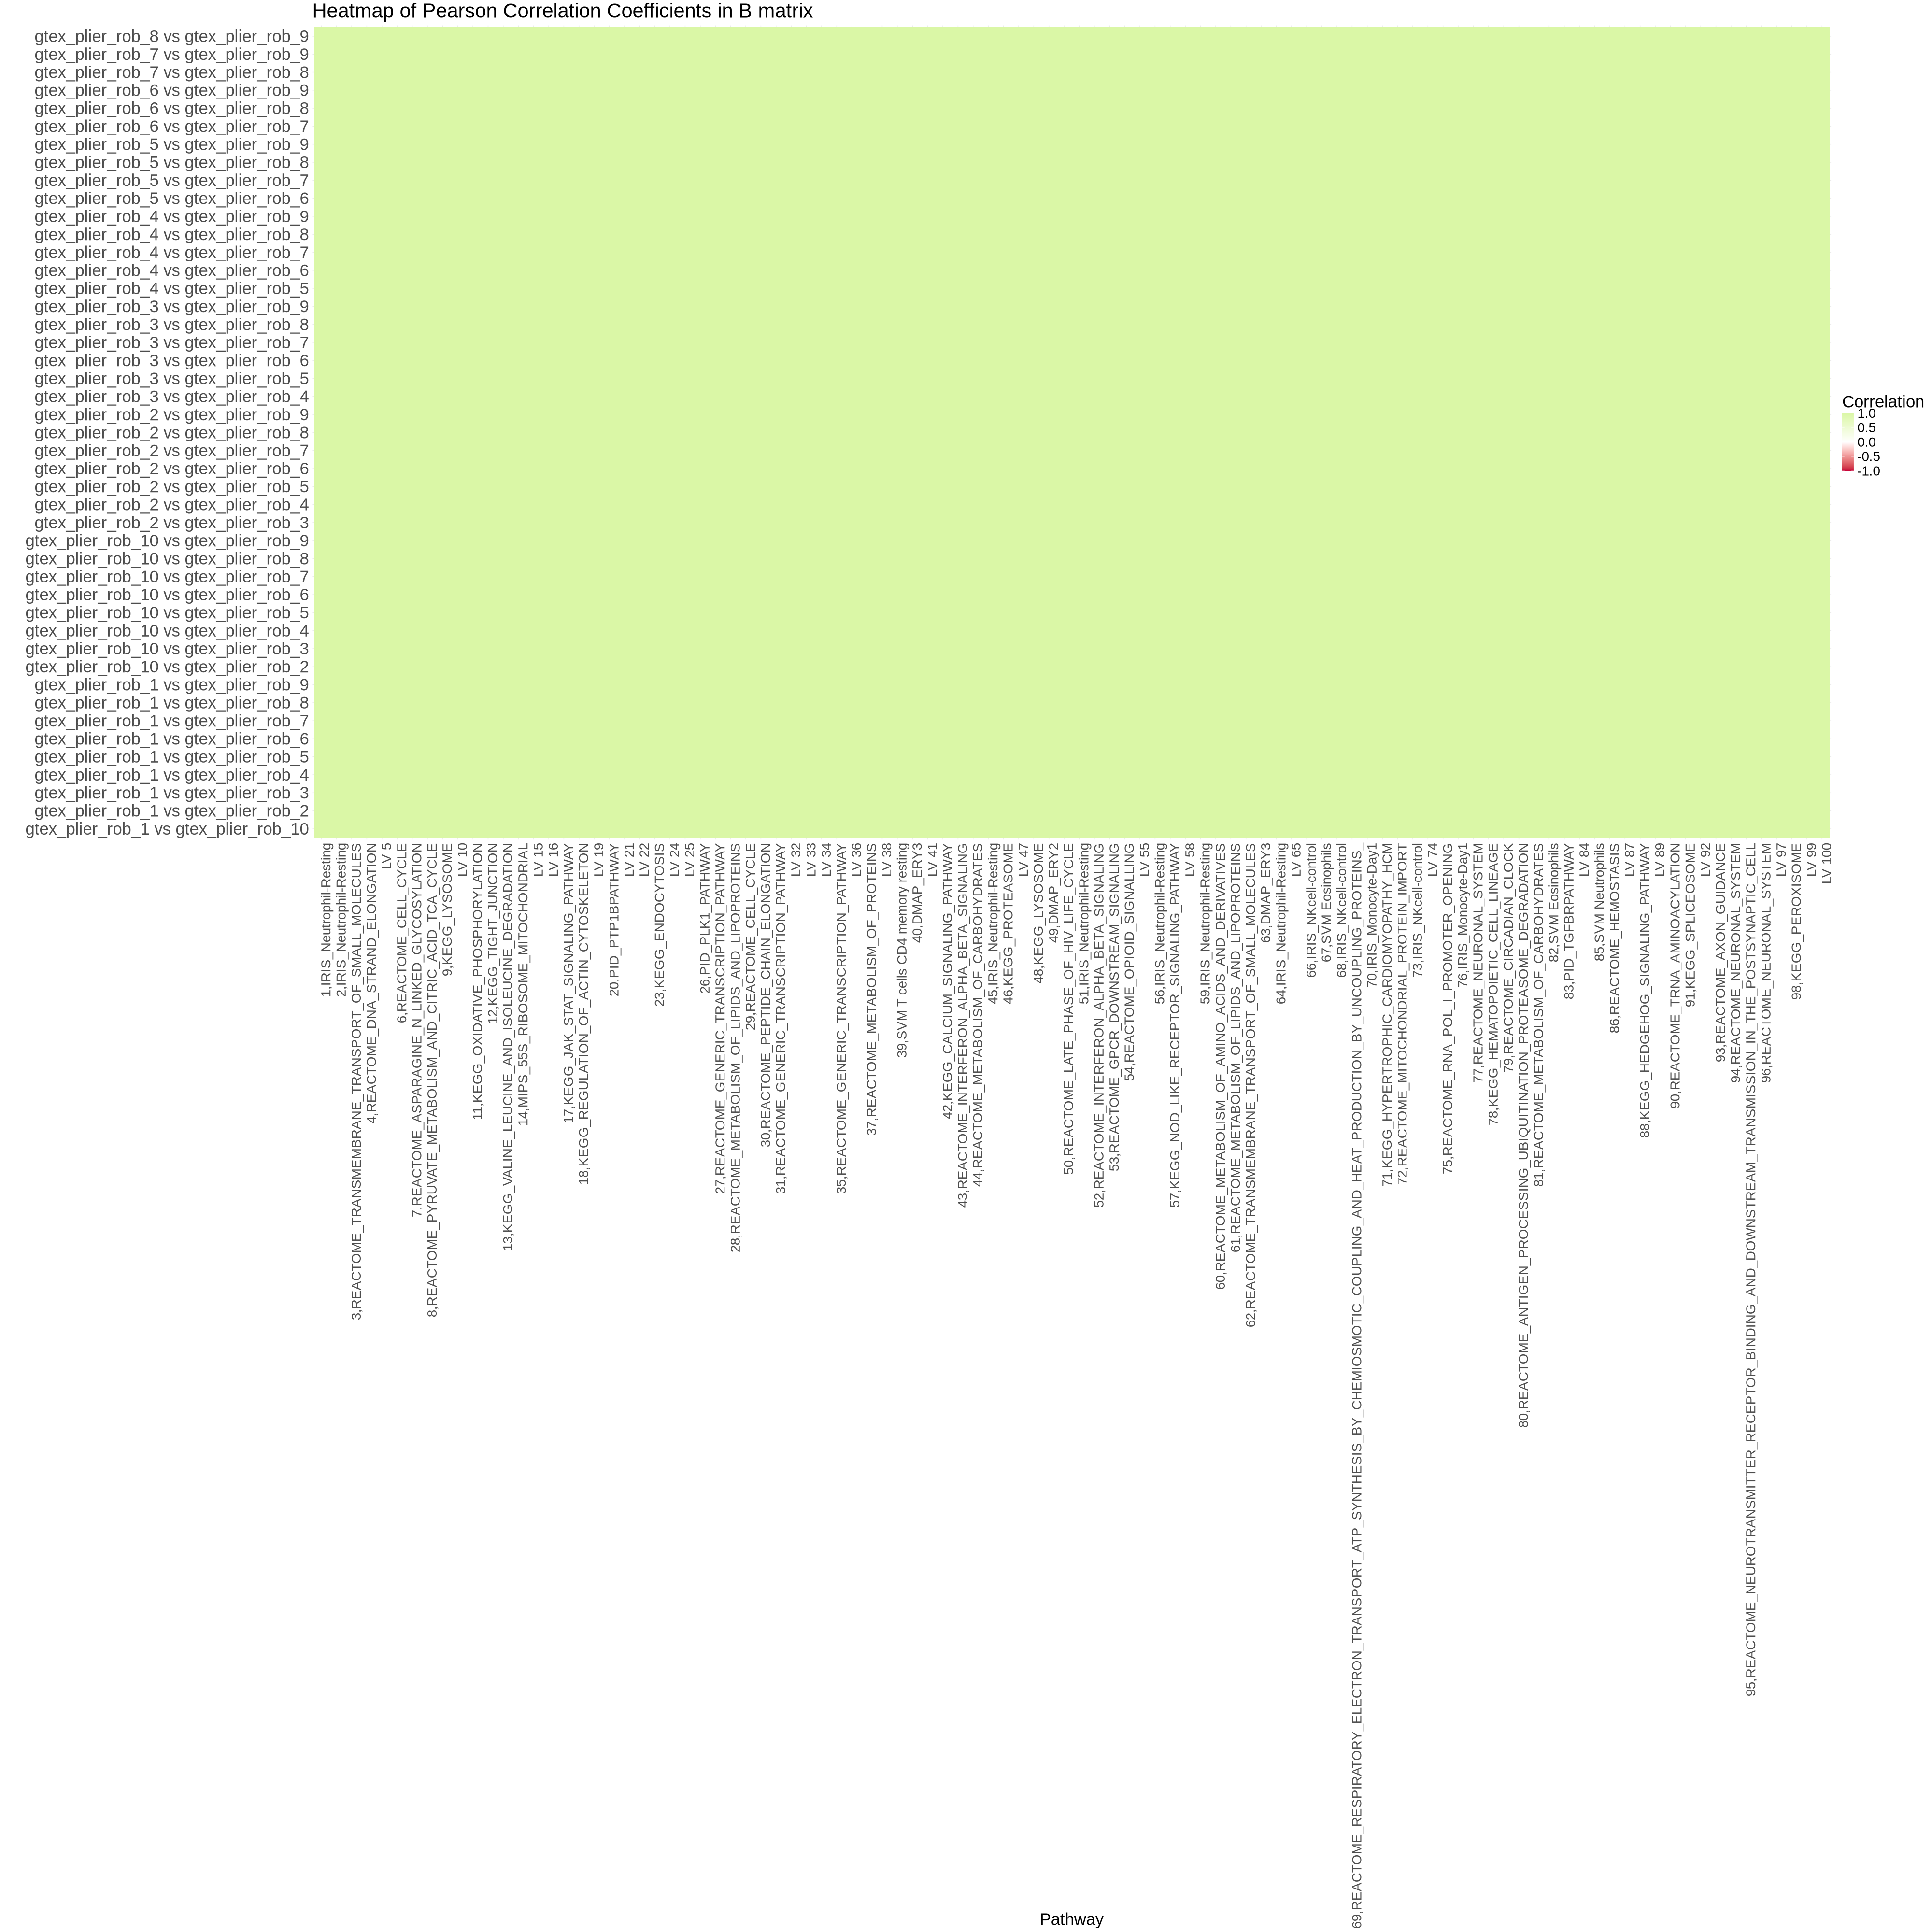

In [14]:
options(repr.plot.width = 40, repr.plot.height = 40, repr.plot.res = 100)

heatmap_data_pw=calculate_pearson_matrices(matrixB_M_list)

ggplot(melt(heatmap_data_pw, id.vars = "Comparison"), aes(x = variable, y = Comparison, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "#C70039", high = "#DAF7A6", mid = "white", midpoint = 0, limit = c(-1, 1), space = "Lab", name = "Correlation") +
  labs(title = "Heatmap of Pearson Correlation Coefficients in B matrix", x = "Pathway", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1),  # Rotate x-axis labels by 90 degrees
    axis.text.y = element_text(size = 25),  # Adjust y-axis text size
    text = element_text(size = 25)  # Adjust other text sizes (plot title, axis labels, etc.)
  )

**How similar is the coverage in pathways and LVs assosiated with them?**

- Pathway: This represents the proportion of "covered" pathways within the analysis. A "covered" pathway refers to a pathway that has been identified.

- LV (Latent Variable): This is about the proportion of LVs that have pathways associated with them. The proportion here indicates how many of these LVs have at least one associated pathway, suggesting a linkage or influence between the LVs and the pathways in question.

- Sig. Pathway by LV: This metric calculates the number of pathways "covered" divided by the number of LVs. Essentially, it provides a ratio indicating the average number of pathways associated with each LV. A higher ratio suggests that, on average, each LV is associated with multiple pathways, which could indicate a more complex relationship between the LVs and the pathways, or possibly a higher degree of coverage and significance in the analysis.

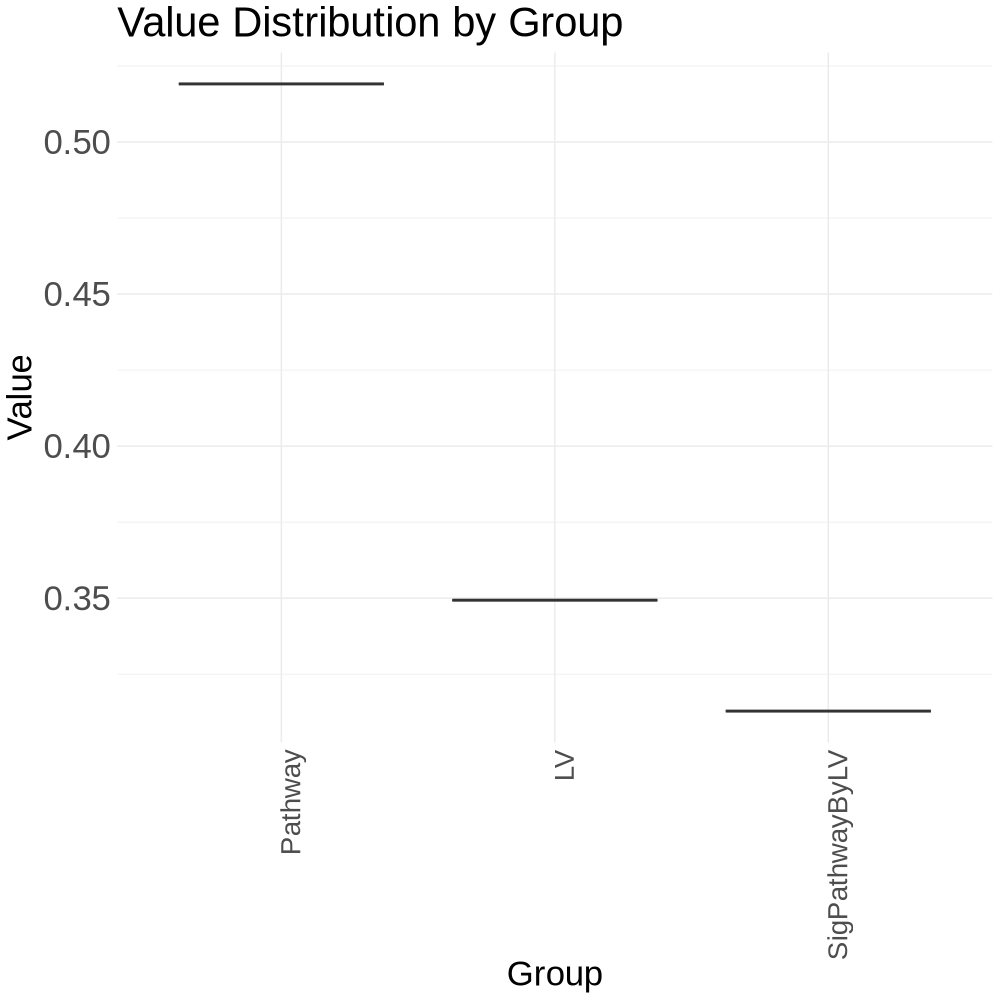

In [15]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

gtex_rob_models_coverage=lapply(gtex_rob_models, GetPathwayCoverage)
pathways <- numeric(length(gtex_rob_models_coverage))
lvs <- numeric(length(gtex_rob_models_coverage))
sig_pathways_by_lv <- numeric(length(gtex_rob_models_coverage))

# Now we loop over the list and extract the values
for (i in seq_along(gtex_rob_models_coverage)) {
  pathways[i] <- gtex_rob_models_coverage[[i]]$pathway
  lvs[i] <- gtex_rob_models_coverage[[i]]$lv
  sig_pathways_by_lv[i] <- gtex_rob_models_coverage[[i]]$sig.pathway.by.lv
}

gtex_df <- data.frame(
  Index = seq_along(gtex_rob_models_coverage),
  Pathway = pathways,
  LV = lvs,
  SigPathwayByLV = sig_pathways_by_lv
)

gtex_melted <- melt(gtex_df, id.vars = 'Index')


ggplot(gtex_melted, aes(x = variable, y = value)) + 
    geom_boxplot() +
    labs(title = "Value Distribution by Group",
       x = "Group",
       y = "Value") +
    theme_minimal() +
    theme(
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1),  # Rotate x-axis labels by 90 degrees
    axis.text.y = element_text(size = 25),  # Adjust y-axis text size
    text = element_text(size = 25)  # Adjust other text sizes (plot title, axis labels, etc.)
)